## 1. Data Exploration

In [1]:
import missingno as msno
import matplotlib.pyplot as plt
import pandas as pd

# Load the CSV file into a DataFrame with low_memory=False to avoid DtypeWarning
data = pd.read_csv('msna_data.csv', low_memory=False)

# Filter the data for the year 2023
data = data[data['year'].astype('int64') == 2023]

# Explore the data
print("\nInformation about the DataFrame:")
print(data.info())

print("\nSummary statistics of the DataFrame:")
print(data.describe(include='all'))

# Display the data types of each column
print("\nData types of each column:")
print(data.dtypes)


Information about the DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 122867 entries, 206576 to 329442
Columns: 199 entries, country to weight
dtypes: float64(105), int64(65), object(29)
memory usage: 187.5+ MB
None

Summary statistics of the DataFrame:
       country      year      msna ADM2_PCODE ADM1_PCODE children_outside_hh  \
count   122867  122867.0    122867     107016     116498              100631   
unique      11       NaN        14        630        132                   2   
top        drc       NaN  drc-2023  NER004005     NER006                  no   
freq     40790       NaN     40790       1274       4437               91393   
mean       NaN    2023.0       NaN        NaN        NaN                 NaN   
std        NaN       0.0       NaN        NaN        NaN                 NaN   
min        NaN    2023.0       NaN        NaN        NaN                 NaN   
25%        NaN    2023.0       NaN        NaN        NaN                 NaN   
50%        NaN   

## 2. Feature Engineering

### 2.1 Data Cleaning

The data cleaning process begins by removing rows with missing values in the target column, `child_sep_severity`. Next, only the relevant variables from the `vars_analysis.csv` file are retained for further analysis. Columns with more than 20% missing values are dropped to ensure data quality. Additionally, columns with zero variance, which provide no useful information, are removed. Variables ending in '_NA' without corresponding non-NA versions are also discarded to avoid redundancy. Missing data patterns are visualized both before and after these cleaning steps. Finally, the cleaned dataset is reviewed to ensure all essential variables remain, with any dropped variables from `vars_analysis` reported.



Shape of the filtered DataFrame, without missing values for the response variable: (99465, 199)

DataFrame after keeping variables in vars_analysis:
<class 'pandas.core.frame.DataFrame'>
Index: 99465 entries, 206576 to 329442
Data columns (total 99 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   water_source                             94527 non-null  object 
 1   shelter_type                             94071 non-null  object 
 2   lcsi_cat                                 43698 non-null  object 
 3   hoh_age                                  83342 non-null  float64
 4   child_adult_ratio                        97438 non-null  float64
 5   num_children                             99465 non-null  float64
 6   num_adults                               99465 non-null  float64
 7   children_0_2                             99465 non-null  float64
 8   children_3_5                       

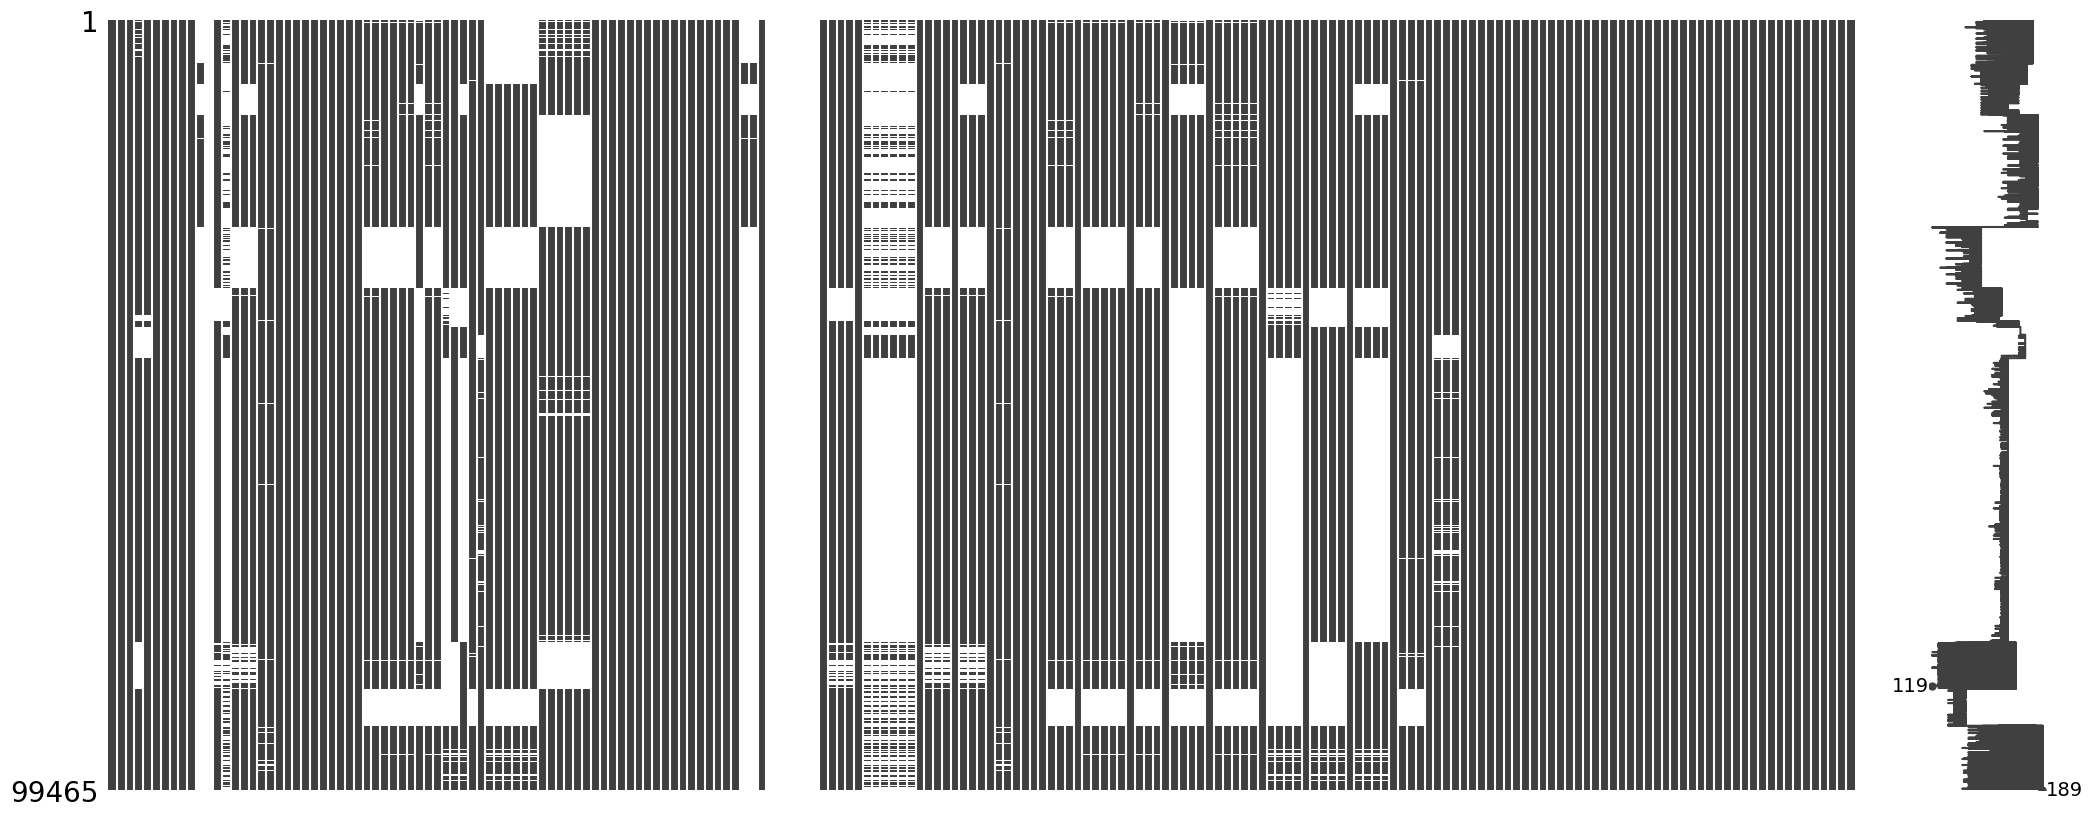

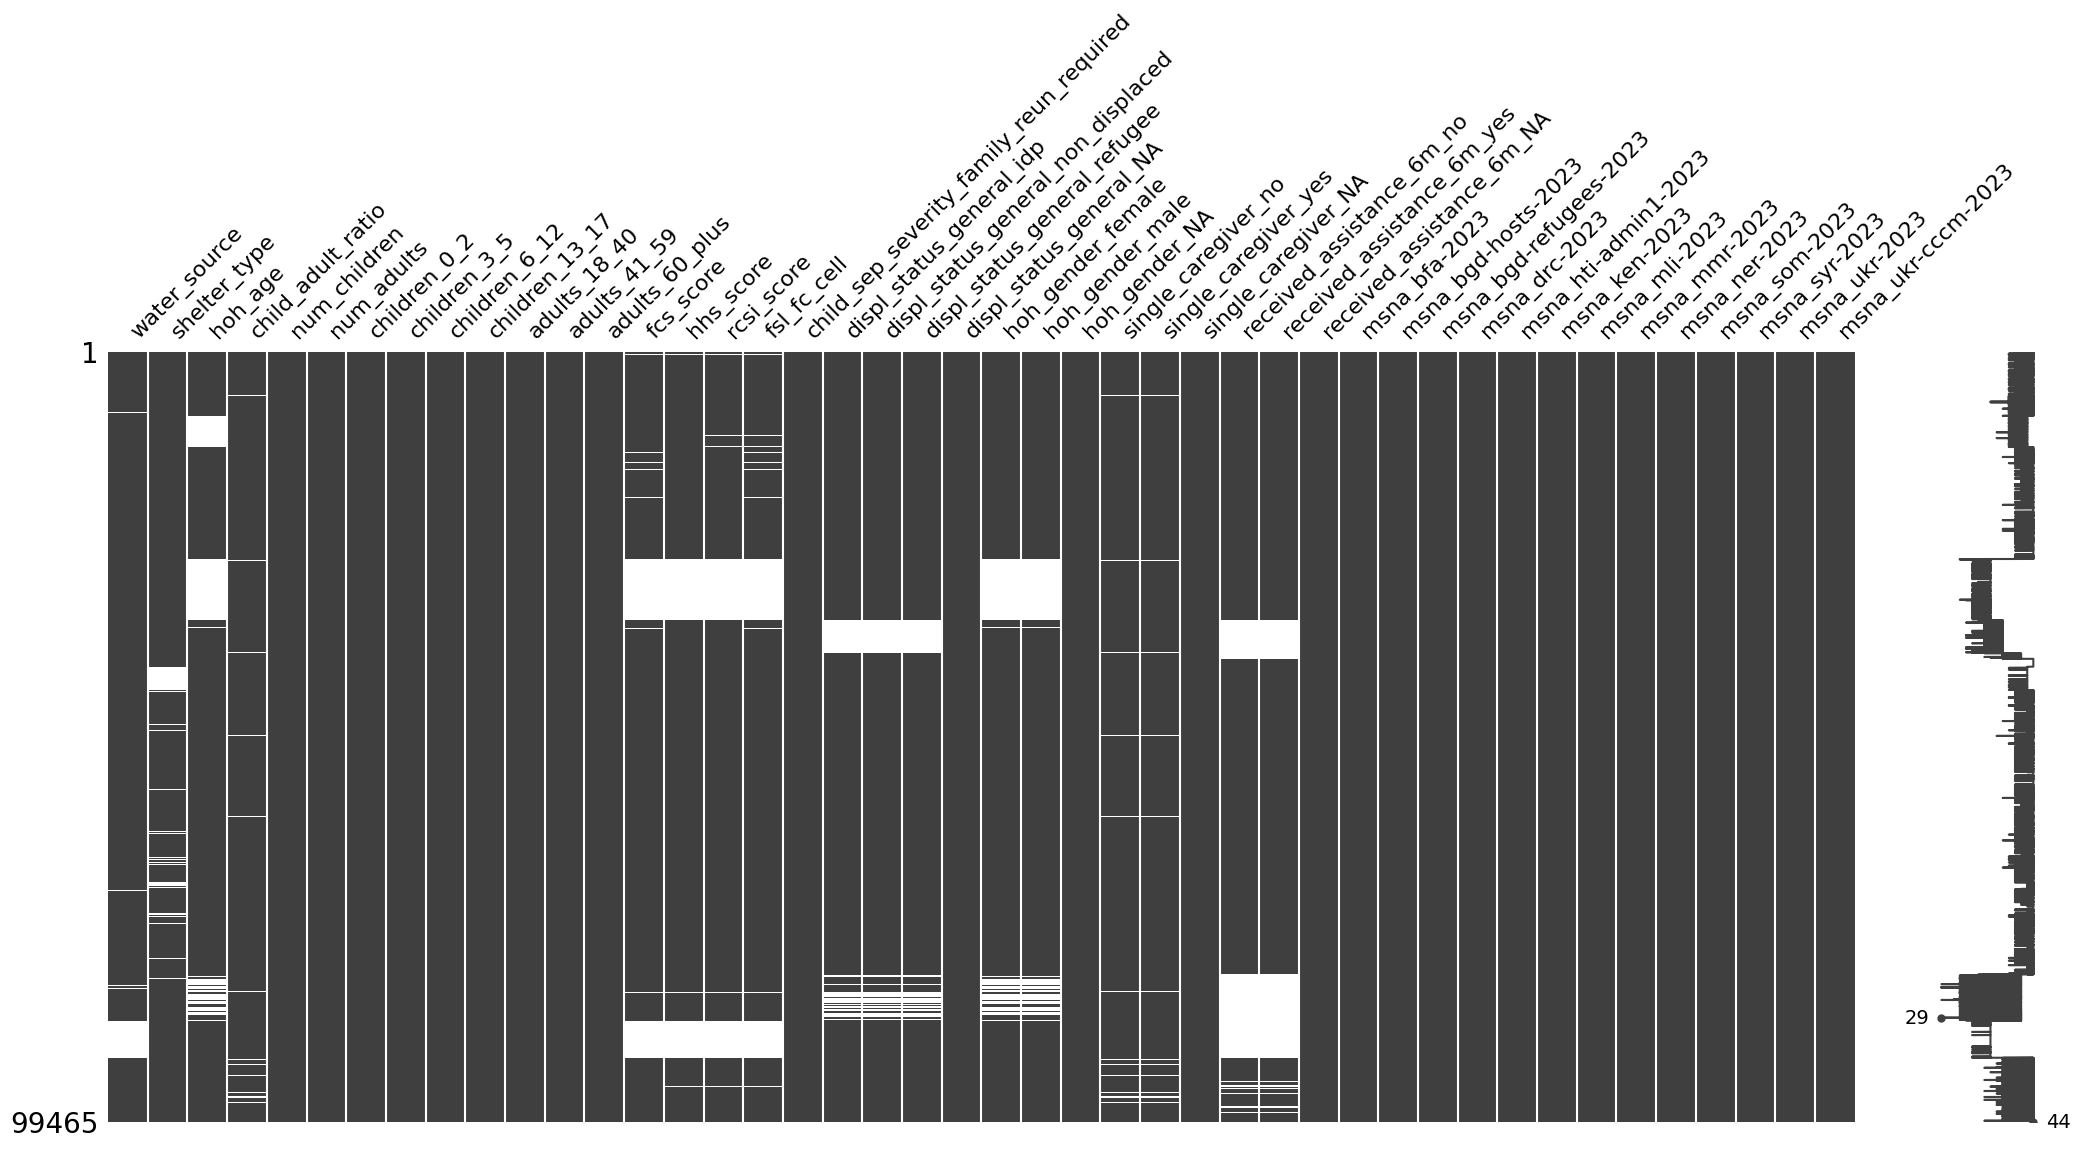


Final DataFrame after dropping unnecessary columns:
<class 'pandas.core.frame.DataFrame'>
Index: 99465 entries, 206576 to 329442
Data columns (total 44 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   water_source                             94527 non-null  object 
 1   shelter_type                             94071 non-null  object 
 2   hoh_age                                  83342 non-null  float64
 3   child_adult_ratio                        97438 non-null  float64
 4   num_children                             99465 non-null  float64
 5   num_adults                               99465 non-null  float64
 6   children_0_2                             99465 non-null  float64
 7   children_3_5                             99465 non-null  float64
 8   children_6_12                            99465 non-null  float64
 9   children_13_17                           99465 non-null  float

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno

# Define function to display and drop columns based on a condition
def drop_columns_with_condition(df, condition, description):
    columns_to_drop = df.columns[condition].tolist()
    if columns_to_drop:
        print(f"\nDropped columns {description}:")
        print(columns_to_drop)
        return df.drop(columns=columns_to_drop)
    return df

# Filter out rows with missing values in the 'child_sep_severity' column
data_filtered = data.dropna(subset=['child_sep_severity'])
print("\nShape of the filtered DataFrame, without missing values for the response variable:", data_filtered.shape)

# Load variables to consider for the model
vars_analysis = pd.read_csv('vars_analysis.csv')['variable'].tolist()

# Select columns that are relevant for analysis
data_select = data_filtered[vars_analysis].copy()
print("\nDataFrame after keeping variables in vars_analysis:")
data_select.info()

# Identify columns with more than 20% missing values
missing_percentage = data_select.isnull().mean() * 100
columns_with_many_missing = missing_percentage > 20

# Drop columns with more than 20% missing values
data_select = drop_columns_with_condition(data_select, columns_with_many_missing, "with more than 20% missing values")

# Drop columns with zero variance (only one unique value)
zero_variance_condition = data_select.nunique() <= 1
data_select = drop_columns_with_condition(data_select, zero_variance_condition, "with zero variance")

# Identify and drop variables ending with '_NA' that have no other variable with the same stem
na_columns = [col for col in data_select.columns if col.endswith('_NA')]
stems = {col[:-3] for col in na_columns}
na_suffix_condition = [col for col in na_columns if not any(other_col.startswith(col[:-3]) and other_col != col for other_col in data_select.columns)]
data_select = drop_columns_with_condition(data_select, data_select.columns.isin(na_suffix_condition), "'_NA' with no matching stem variable")

# Assign the final cleaned data to data_select_na
data_select_na = data_select

# Visualize missing data matrix before dropping columns
msno.matrix(data_filtered)
plt.show()

# Visualize missing data matrix after dropping columns
msno.matrix(data_select_na)
plt.show()

# Display final DataFrame info
print("\nFinal DataFrame after dropping unnecessary columns:")
data_select_na.info()

# Check and display which variables from vars_analysis are no longer in the data
missing_vars = [var for var in vars_analysis if var not in data_select_na.columns]
print("\nVariables from vars_analysis no longer in the data:", missing_vars)


### 2.2 Change Encoding of Ordinal Variables

The script converts one-hot encoded ordinal variables into a more appropriate label-encoded format. It begins by loading a mapping of old one-hot labels and new ordinal labels from `new_labels.csv`, filtering for variables present in the dataset. The script then replaces one-hot encoded values with the corresponding ordinal labels and converts the recoded variables to integer type, ensuring proper handling of missing values. It verifies that all required variables have been recoded and displays the updated data along with the data types of the recoded variables.


In [3]:
# Load the new_labels CSV file and filter for variables present in the data
new_labels = pd.read_csv('new_labels.csv', usecols=['variable', 'label_old', 'label_new'])
new_labels = new_labels[new_labels['variable'].isin(data_select_na.columns)]

print("\nLoaded new_labels DataFrame:")
print(new_labels.head())

# Create a copy of data_select_na to apply changes
data_ord = data_select_na.copy()

# Apply the label mapping to the data_ord DataFrame
for _, row in new_labels.iterrows():
    variable = row['variable']
    label_old = row['label_old']
    label_new = int(row['label_new'])  # Convert label_new to integer
    
    if variable in data_ord.columns:
        data_ord[variable] = data_ord[variable].replace(label_old, label_new)

# Define recoded_variables
recoded_variables = new_labels['variable'].unique()

# Convert the recoded variables to integer type
for variable in recoded_variables:
    if variable in data_ord.columns:
        data_ord[variable] = data_ord[variable].fillna(pd.NA).astype('Int64')  # Fill NaNs with pd.NA before converting

# Check if recoded_variables are in data_ord
variables_in_data_ord = all(variable in data_ord.columns for variable in recoded_variables)
print(f"All recoded variables are in data_ord: {variables_in_data_ord}")

# Identify which variables are not in data_ord
missing_variables = [variable for variable in recoded_variables if variable not in data_ord.columns]
print(f"Variables not in data_ord: {missing_variables}")

# Display the first few rows of the recoded variables in the data_ord DataFrame
print("\nRecoded variables in data_ord DataFrame:")
print(data_ord[recoded_variables].head())

# Display the variable types of the recoded variables
print("\nVariable types of recoded variables:")
print(data_ord[recoded_variables].dtypes)


Loaded new_labels DataFrame:
       variable   label_old  label_new
0  shelter_type    adequate          1
1  shelter_type  inadequate          2
2  shelter_type  no_shelter          3
3  water_source    improved          1
4  water_source  unimproved          2
All recoded variables are in data_ord: True
Variables not in data_ord: []

Recoded variables in data_ord DataFrame:
        shelter_type  water_source
206576             1             1
206577             1             1
206578             1             1
206579             1             1
206580             1             1

Variable types of recoded variables:
shelter_type    Int64
water_source    Int64
dtype: object


C:\Users\jasper.linke\AppData\Local\Temp\ipykernel_33552\1119195321.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_ord[variable] = data_ord[variable].replace(label_old, label_new)


### 2.4 KNN Imputation of Remaining Missing Values

Next, we use **K-Nearest Neighbors (KNN) imputation** to handle missing values across all columns in the dataset. It first applies the `KNNImputer` to estimate and replace missing values based on the nearest neighbors. After imputation, the missing data is visualized, and the updated dataset with the imputed values is displayed for verification.

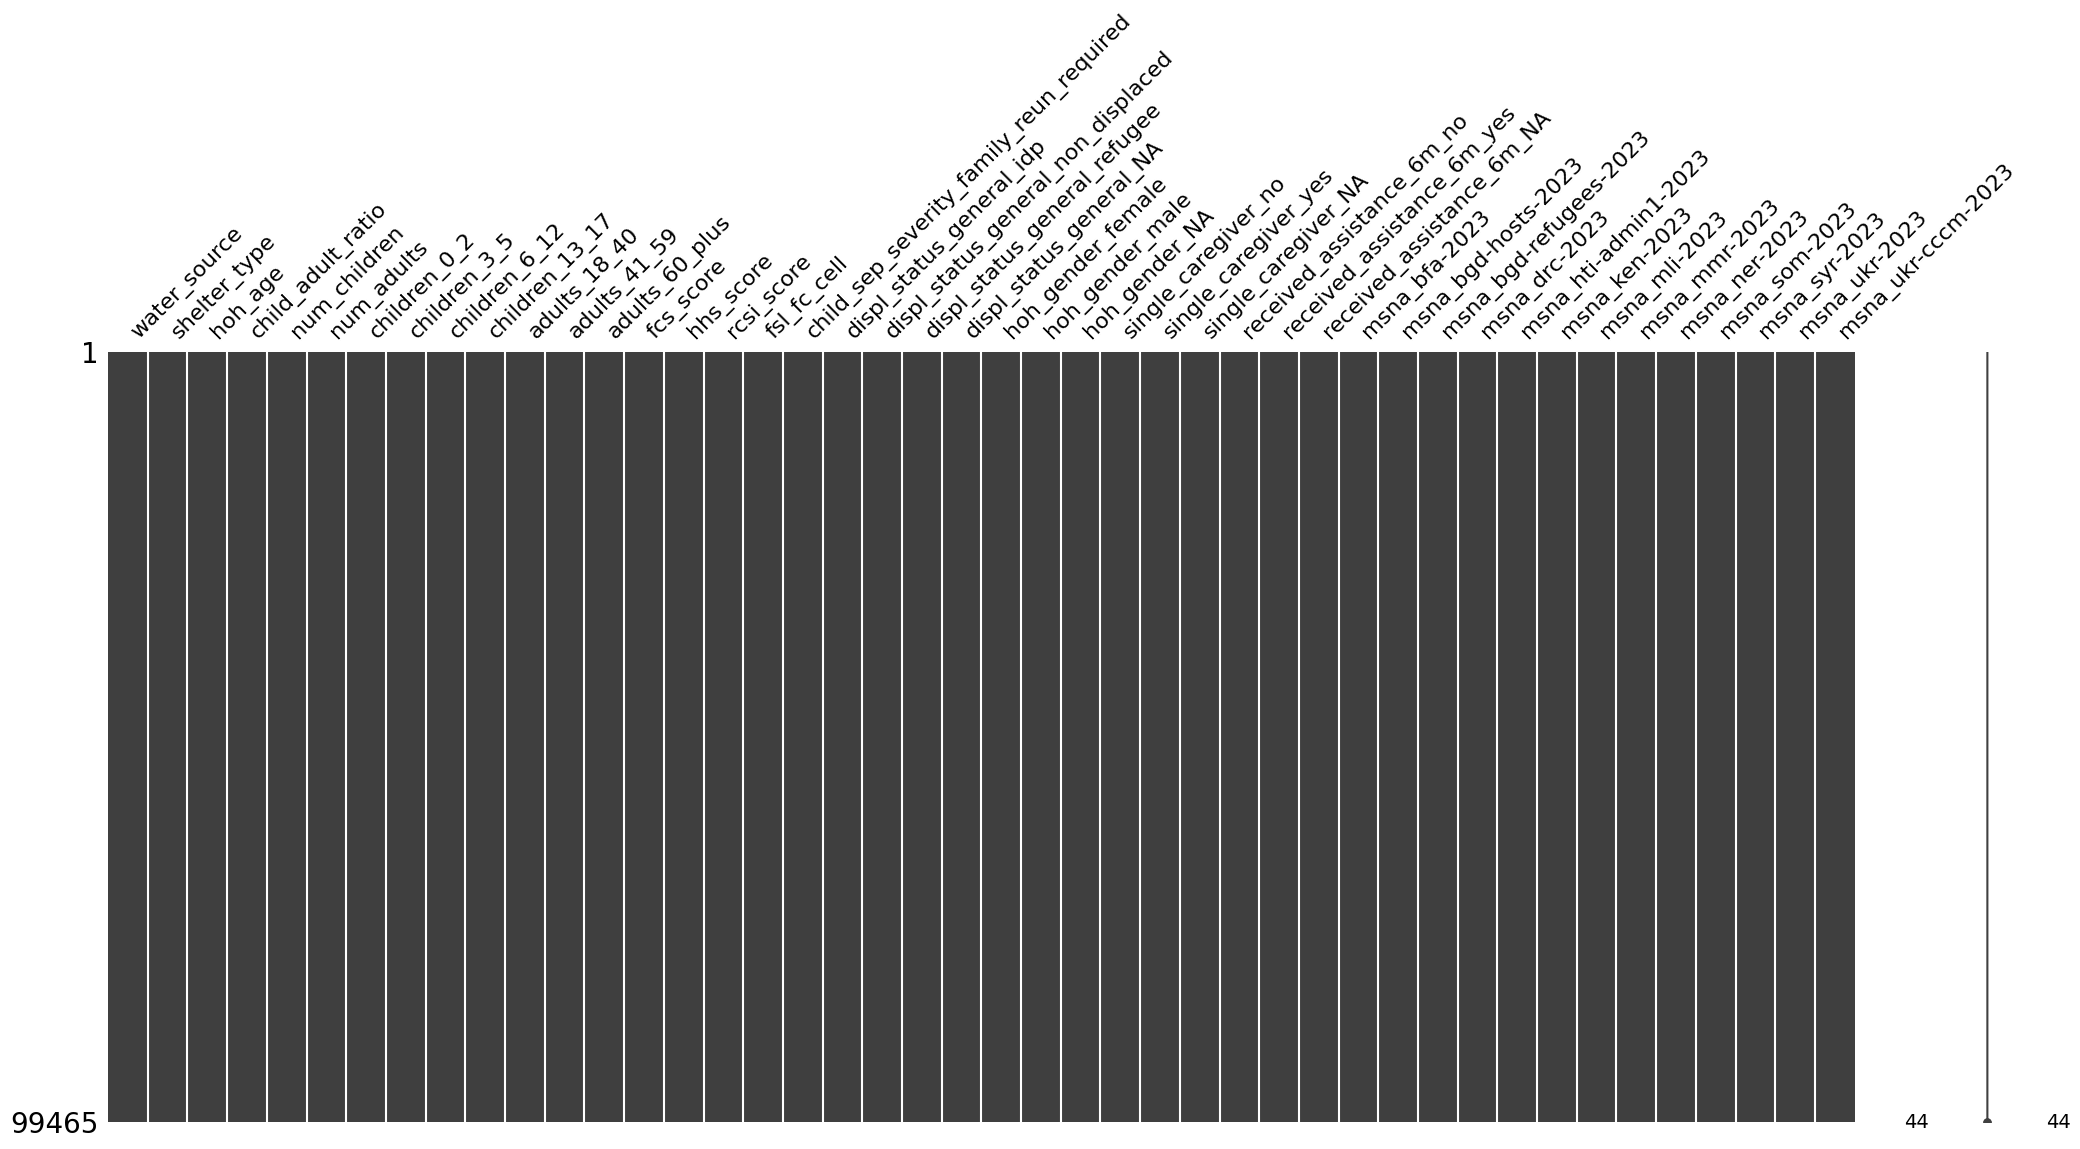


DataFrame with imputed values in all columns:
   water_source  shelter_type  hoh_age  child_adult_ratio  num_children  \
0           1.0           1.0     48.0               1.00           3.0   
1           1.0           1.0     37.0               1.00           2.0   
2           1.0           1.0     36.0               2.25           9.0   
3           1.0           1.0     44.0               2.00           4.0   
4           1.0           1.0     54.0               1.50           3.0   

   num_adults  children_0_2  children_3_5  children_6_12  children_13_17  ...  \
0         3.0           1.0           1.0            0.0             1.0  ...   
1         2.0           0.0           1.0            1.0             0.0  ...   
2         4.0           0.0           2.0            3.0             4.0  ...   
3         2.0           0.0           1.0            2.0             1.0  ...   
4         2.0           0.0           1.0            2.0             0.0  ...   

   msna_drc-202

In [4]:
import pandas as pd
from sklearn.impute import KNNImputer
import missingno as msno
import matplotlib.pyplot as plt

# Function to apply K-Nearest Neighbors Imputation to all columns
def knn_impute_all_columns(df, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    return df_imputed

# Apply KNN imputation to all columns
data_na_imp = knn_impute_all_columns(data_ord.copy())

# Visualize missing data matrix
msno.matrix(data_na_imp)
plt.show()

# Display the first few rows of the new dataframe with imputed values
print("\nDataFrame with imputed values in all columns:")
print(data_na_imp.head())

# Display the first few rows of the new dataframe with imputed values
print("\nDataFrame with imputed values in the first column:")
print(data_na_imp.head())

### 2.5 Standardization

This process standardizes the **numerical variables** in the dataset while preserving categorical and dummy variables. After identifying variable types from `vars_analysis.csv`, only numerical variables are standardized using `StandardScaler` to ensure a mean of 0 and standard deviation of 1. Categorical variables are added back without standardization. The script displays summary statistics before and after standardization and visualizes the distribution of the `num_children` variable with histograms to illustrate the effect of standardization.


Summary statistics before standardization:
       water_source  shelter_type       hoh_age  child_adult_ratio  \
count  99465.000000  99465.000000  99465.000000       99465.000000   
mean       1.462728      1.267829     43.574825           1.529930   
std        0.654146      0.437580     12.462860           1.127265   
min        1.000000      1.000000     15.000000           0.035714   
25%        1.000000      1.000000     34.600000           0.666667   
50%        1.000000      1.000000     42.000000           1.333333   
75%        2.000000      1.800000     51.000000           2.000000   
max        3.000000      3.000000    101.000000          14.000000   

       num_children    num_adults  children_0_2  children_3_5  children_6_12  \
count  99465.000000  99465.000000  99465.000000  99465.000000   99465.000000   
mean       3.195154      2.513970      0.447434      0.646569       1.382878   
std        1.940467      1.286772      0.626657      0.743152       1.234360   
min  

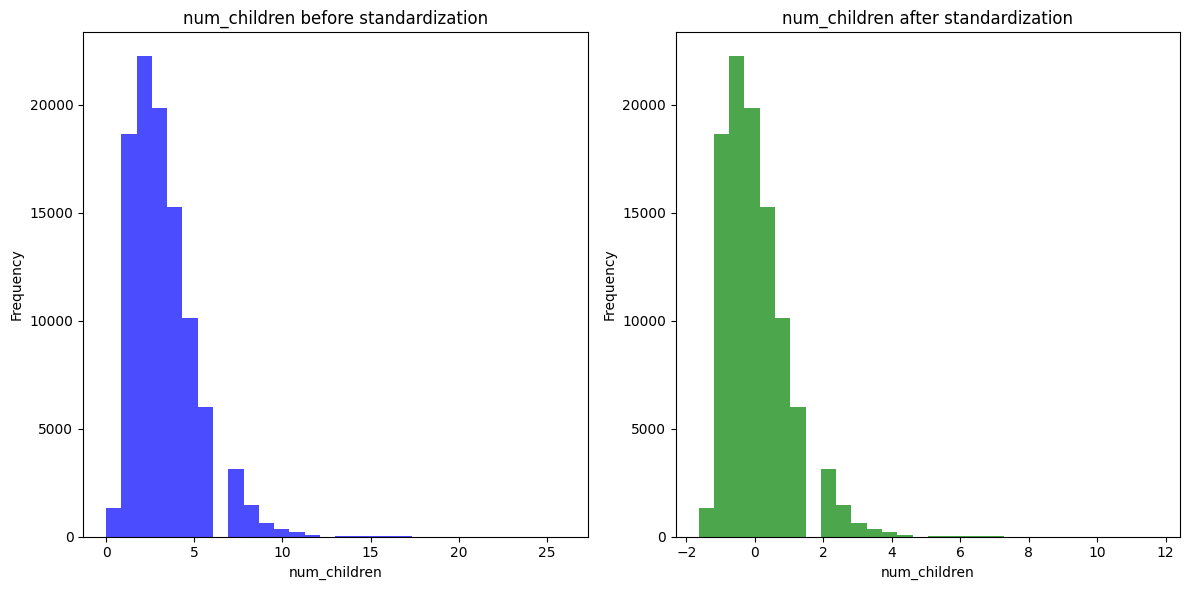

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Load the vars_analysis.csv to identify variable types
vars_analysis = pd.read_csv('vars_analysis.csv', usecols=['variable', 'type'])
dummy_variables = vars_analysis[vars_analysis['type'] == 'dummy']['variable'].tolist()
categorical_variables = vars_analysis[vars_analysis['type'] == 'ordinal']['variable'].tolist()
numerical_variables = vars_analysis[vars_analysis['type'] == 'numerical']['variable'].tolist()

# Filter variables to include only those present in data_dum
dummy_variables = [var for var in dummy_variables if var in data_na_imp.columns]
categorical_variables = [var for var in categorical_variables if var in data_na_imp.columns]
numerical_variables = [var for var in numerical_variables if var in data_na_imp.columns]

# Standardize the numerical variables (excluding dummy variables and categorical variables)
scaler = StandardScaler()
data_stand = data_na_imp.copy()
data_stand[numerical_variables] = scaler.fit_transform(data_stand[numerical_variables])

# Add back the categorical variables without standardizing them
common_categorical_vars = list(set(categorical_variables).intersection(data_na_imp.columns))
data_stand[common_categorical_vars] = data_na_imp[common_categorical_vars]

# Display summary statistics before standardization
print("\nSummary statistics before standardization:")
print(data_na_imp.describe())

# Display summary statistics after standardization
print("\nSummary statistics after standardization:")
print(data_stand.describe())

# Histogram for hoh_age before standardization
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(data_na_imp['num_children'], bins=30, alpha=0.7, color='blue')
plt.title('num_children before standardization')
plt.xlabel('num_children')
plt.ylabel('Frequency')

# Histogram for num_children after standardization
plt.subplot(1, 2, 2)
plt.hist(data_stand['num_children'], bins=30, alpha=0.7, color='green')
plt.title('num_children after standardization')
plt.xlabel('num_children')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## 3. Feature Selection

This process performs **feature selection** using various methods to identify the most important features for predicting the target variable. The dataset is first prepared by ensuring all features are numeric, free of missing values, and standardized. Several feature selection methods are applied:
1. **Recursive Feature Elimination (RFE)**: Selects features by recursively removing the least important ones based on a logistic regression model.
2. **Random Forest Feature Importance**: Identifies the top features based on the importance scores from a Random Forest model.
3. **Elastic Net Regularization**: Selects features based on the non-zero coefficients from an Elastic Net model.
4. **Boruta Algorithm**: A wrapper method using Random Forest to identify all relevant features.
5. **Mutual Information**: Measures the dependency between each feature and the target.

Finally, the selected features from all methods are combined, and the dataset is filtered to retain only those features, preparing it for further analysis or modeling.

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from boruta import BorutaPy
import shap
import pickle

# Assuming data_stand is already defined and loaded

# Create a copy of data_stand for feature selection
data_fs = data_stand.copy()

# Separate features and target variable
X = data_fs.drop(columns=['child_sep_severity_family_reun_required'])
y = data_fs['child_sep_severity_family_reun_required']

### Convert All Variables to Float ###

# Force all features to float64
X = X.astype(np.float64)
y = y.astype(np.float64)

### Utility Functions for Checks ###

# Check if all columns are numeric
def check_numeric(df):
    if df.select_dtypes(include=[np.number]).shape[1] != df.shape[1]:
        raise ValueError("All features must be numeric. Please convert categorical variables to numeric format.")

# Check for missing values
def check_no_missing(df):
    if df.isnull().sum().sum() > 0:
        raise ValueError("Input data contains missing values. Please handle missing data before applying these methods.")

# Ensure target variable is binary or multiclass
def check_target(y):
    if not pd.api.types.is_numeric_dtype(y):
        raise ValueError("Target variable 'y' must be numeric.")
    if len(y.unique()) < 2:
        raise ValueError("Target variable 'y' must have at least two classes for classification.")

# Check if data is standardized and print variables that are not
def check_standardized(df, mean_threshold=0.01, std_threshold=0.01):
    # Calculate the absolute difference of means from 0 and standard deviations from 1
    mean_diff = df.mean().abs()  # Difference from 0 for means
    std_diff = (df.std() - 1).abs()  # Difference from 1 for standard deviations

    # Identify columns that are not standardized
    non_standardized_vars = df.columns[(mean_diff > mean_threshold) | (std_diff > std_threshold)].tolist()
    
    # Print warning only if there are non-standardized variables
    if non_standardized_vars:
        print("Warning: The following variables do not appear to be standardized (mean ≈ 0, std ≈ 1):")
        print(non_standardized_vars)

### 1. Ensure Input Data is Correct for Each Method ###

# Check target variable
check_target(y)

# Check if features are numeric and have no missing values
check_numeric(X)
check_no_missing(X)

### 2. Check Standardization for Methods Sensitive to Scale ###
check_standardized(X)

### 3. Recursive Feature Elimination (RFE) ###
try:
    print("Running RFE...")
    model = LogisticRegression(max_iter=1000)
    rfe = RFE(model, n_features_to_select=10)
    X_rfe = rfe.fit_transform(X, y)
    print(f"Features after RFE: {X_rfe.shape[1]}")
except Exception as e:
    print(f"Error running RFE: {e}")

### 4. Feature Importance from Tree-Based Models ###
try:
    print("Running Random Forest...")
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)

    # Get feature importances
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_features_rf = X.columns[indices[:10]]
    print(f"Top features according to Random Forest: {top_features_rf}")
except Exception as e:
    print(f"Error running Random Forest: {e}")

### 5. Elastic Net Regularization ###
try:
    print("Running Elastic Net...")
    elastic_net = ElasticNetCV(cv=5, random_state=42)
    elastic_net.fit(X, y)
    enet_coef = pd.Series(elastic_net.coef_, index=X.columns)
    top_features_enet = enet_coef[enet_coef != 0].index
    print(f"Top features according to Elastic Net: {top_features_enet}")
except Exception as e:
    print(f"Error running Elastic Net: {e}")

### 6. Boruta Algorithm ###
try:
    print("Running Boruta...")
    boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)
    boruta_selector.fit(X.values, y)
    boruta_features = X.columns[boruta_selector.support_].tolist()
    print(f"Top features according to Boruta: {boruta_features}")
except Exception as e:
    print(f"Error running Boruta: {e}")

### 7. Mutual Information ###
try:
    print("Calculating Mutual Information...")
    mi = mutual_info_classif(X, y)
    mi_features = X.columns[np.argsort(mi)[-10:]].tolist()
    print(f"Top features according to Mutual Information: {mi_features}")
except Exception as e:
    print(f"Error calculating Mutual Information: {e}")

### Combine Results for the Most Relevant Features ###
try:
    combined_features = set(top_features_rf) | set(top_features_enet) | set(boruta_features) | set(mi_features)
    print(f"Combined selected features: {combined_features}")
except Exception as e:
    print(f"Error combining selected features: {e}")

### Drop Unselected Features ###

# Find the intersection of selected features from all methods
selected_features = list(combined_features)  # Convert set to list for indexing

# Filter the original dataset to keep only the selected features
X_selected = X[selected_features]

# Print the shape of the new dataset to confirm feature selection
print(f"Shape of data after dropping unselected features: {X_selected.shape}")

### Save X_selected and y to Pickle ###

try:
    with open('X_selected.pkl', 'wb') as f:
        pickle.dump(X_selected, f)
    
    with open('y.pkl', 'wb') as f:
        pickle.dump(y, f)

    print("DataFrames X_selected and y saved as pickle files.")
except Exception as e:
    print(f"Error saving DataFrames as pickle files: {e}")


['water_source', 'shelter_type', 'displ_status_general_idp', 'displ_status_general_non_displaced', 'displ_status_general_refugee', 'displ_status_general_NA', 'hoh_gender_female', 'hoh_gender_male', 'hoh_gender_NA', 'single_caregiver_no', 'single_caregiver_yes', 'single_caregiver_NA', 'received_assistance_6m_no', 'received_assistance_6m_yes', 'received_assistance_6m_NA', 'msna_bfa-2023', 'msna_bgd-hosts-2023', 'msna_bgd-refugees-2023', 'msna_drc-2023', 'msna_hti-admin1-2023', 'msna_ken-2023', 'msna_mli-2023', 'msna_mmr-2023', 'msna_ner-2023', 'msna_som-2023', 'msna_syr-2023', 'msna_ukr-2023', 'msna_ukr-cccm-2023']
Running RFE...
Features after RFE: 10
Running Random Forest...
Top features according to Random Forest: Index(['fcs_score', 'hoh_age', 'rcsi_score', 'fsl_fc_cell',
       'child_adult_ratio', 'hhs_score', 'num_children', 'children_6_12',
       'adults_18_40', 'water_source'],
      dtype='object')
Running Elastic Net...
Top features according to Elastic Net: Index(['shelter_t

## 4. Data Splitting

Next, we split the dataset into **training**, **validation**, and **test** sets while maintaining the class distribution due to the highly imbalanced nature of the target variable.

1. **Initial Split**: The dataset is first divided into an 80% **train + validation** set and a 20% **test set**.
2. **Train/Validation Split**: The train + validation set is further split into a 75% **training set** and a 25% **validation set**.
   - This results in:
     - **Training Set**: 60% of the original data
     - **Validation Set**: 20% of the original data
     - **Test Set**: 20% of the original data
3. **Class Distribution**: After splitting, the number of samples and the class distribution (for both classes 0 and 1) are printed for each dataset to ensure the splits maintain the correct proportions of each class.

This ensures proper stratified splitting of the dataset for training, hyperparameter tuning, and final testing.

In [8]:
import pickle

# Load the saved DataFrames
with open('X_selected.pkl', 'rb') as f:
    X_selected = pickle.load(f)
with open('y.pkl', 'rb') as f:
    y = pickle.load(f)

from sklearn.model_selection import train_test_split

# First, create a train + validation set and a test set (e.g., 80% train/validation, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)

# Then, split the train + validation set into the actual training set and validation set (e.g., 75% train, 25% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)

# Result:
# - X_train, y_train: Training data (60% of the original dataset)
# - X_val, y_val: Validation data (20% of the original dataset)
# - X_test, y_test: Test data (20% of the original dataset)

# Print the structure of the resulting srint("Training Set")
print(f"  Features: {X_train.shape[1]}")
print(f"  Samples: {X_train.shape[0]}")
print(f"  Class 0: {np.sum(y_train == 0)}")
print(f"  Class 1: {np.sum(y_train == 1)}")
print("\nValidation Set")
print(f"  Features: {X_val.shape[1]}")
print(f"  Samples: {X_val.shape[0]}")
print(f"  Class 0: {np.sum(y_val == 0)}")
print(f"  Class 1: {np.sum(y_val == 1)}")
print("\nTest Set")
print(f"  Features: {X_test.shape[1]}")
print(f"  Samples: {X_test.shape[0]}")
print(f"  Class 0: {np.sum(y_test == 0)}")
print(f"  Class 1: {np.sum(y_test == 1)}")

Training Set
  Features: 24
  Samples: 59679
  Class 0: 59450
  Class 1: 229

Validation Set
  Features: 24
  Samples: 19893
  Class 0: 19817
  Class 1: 76

Test Set
  Features: 24
  Samples: 19893
  Class 0: 19817
  Class 1: 76


## 5. Data Balancing

This script applies **SMOTEENN (Synthetic Minority Over-sampling Technique + Edited Nearest Neighbors)** to balance the training data and ensure feature consistency between the training, validation, and test sets.

1. **SMOTEENN**: Balances the training data by oversampling the minority class and removing noisy samples from the majority class, resulting in `X_train_resampled` and `y_train_resampled`.
2. **Column Check (Before Reindexing)**: The script checks for any missing or extra columns in `X_val` and `X_test` compared to `X_train_resampled`, identifying any discrepancies in feature alignment.
3. **Reindexing**: Validation and test sets are reindexed to ensure they have the same columns as `X_train_resampled`, with missing columns filled with zeros.
4. **Column Check (After Reindexing)**: A second check confirms that the feature columns in `X_val` and `X_test` now match the resampled training set.
5. **Class Distribution**: The script displays the original and resampled class distributions, illustrating the effect of SMOTEENN on balancing the dataset.

This step ensures that the resampled training data is balanced and that the validation and test sets are aligned with the training data for consistent model evaluation.

In [9]:
from imblearn.combine import SMOTEENN
from collections import Counter

# Apply SMOTEENN to balance the training data
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# Check for column mismatches before reindexing
print("Checking for column mismatches before reindexing...")

# Find columns missing in X_val or X_test
missing_in_val = set(X_train_resampled.columns) - set(X_val.columns)
missing_in_test = set(X_train_resampled.columns) - set(X_test.columns)

# Find extra columns in X_val or X_test
extra_in_val = set(X_val.columns) - set(X_train_resampled.columns)
extra_in_test = set(X_test.columns) - set(X_train_resampled.columns)

print(f"Columns missing in X_val: {missing_in_val}")
print(f"Columns missing in X_test: {missing_in_test}")
print(f"Extra columns in X_val: {extra_in_val}")
print(f"Extra columns in X_test: {extra_in_test}")

# Reindex the validation and test sets to match the training set
X_val = X_val.reindex(columns=X_train_resampled.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train_resampled.columns, fill_value=0)

# Check again for column mismatches after reindexing
print("\nChecking for column mismatches after reindexing...")

# Find columns missing in X_val or X_test (there should be none now)
missing_in_val_after = set(X_train_resampled.columns) - set(X_val.columns)
missing_in_test_after = set(X_train_resampled.columns) - set(X_test.columns)

# Find extra columns in X_val or X_test (there should be none now)
extra_in_val_after = set(X_val.columns) - set(X_train_resampled.columns)
extra_in_test_after = set(X_test.columns) - set(X_train_resampled.columns)

print(f"Columns missing in X_val after reindexing: {missing_in_val_after}")
print(f"Columns missing in X_test after reindexing: {missing_in_test_after}")
print(f"Extra columns in X_val after reindexing: {extra_in_val_after}")
print(f"Extra columns in X_test after reindexing: {extra_in_test_after}")

# Print class distribution after resampling
print(f"\nOriginal class distribution: {Counter(y_train)}")
print(f"Resampled class distribution: {Counter(y_train_resampled)}")

Checking for column mismatches before reindexing...
Columns missing in X_val: set()
Columns missing in X_test: set()
Extra columns in X_val: set()
Extra columns in X_test: set()

Checking for column mismatches after reindexing...
Columns missing in X_val after reindexing: set()
Columns missing in X_test after reindexing: set()
Extra columns in X_val after reindexing: set()
Extra columns in X_test after reindexing: set()

Original class distribution: Counter({0.0: 59450, 1.0: 229})
Resampled class distribution: Counter({1.0: 59450, 0.0: 57577})


## 6. Model Selection

This code performs hyperparameter tuning on three models using **GridSearchCV** with **recall** as the evaluation metric, focusing on optimizing for the minority class in an imbalanced dataset.

**Models Defined:**
1. **Random Forest**:
   - Handles class imbalance using `class_weight='balanced'`.
   - Tuned hyperparameters: `n_estimators`, `max_depth`, and `min_samples_split`.

2. **Logistic Regression**:
   - Uses `class_weight='balanced'` to address imbalance.
   - Tuned hyperparameter: `C` (inverse regularization strength).

3. **XGBoost**:
   - Handles class imbalance using `scale_pos_weight` calculated as the ratio of majority to minority class.
   - Tuned hyperparameters: `learning_rate`, `n_estimators`, and `max_depth`.

**Hyperparameter Tuning:**
- **GridSearchCV** is used with 5-fold cross-validation.
- The **scoring** metric is set to **recall** to focus on detecting the minority class.
- For each model, the best set of hyperparameters is selected and stored in the `best_models` dictionary.

**Output:**
- The best hyperparameters for each model are printed after tuning.


In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import pickle

# Define candidate models with class weighting for imbalance handling
models = {
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000),
    'XGBoost': XGBClassifier(scale_pos_weight=len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1]), random_state=42)
}

# Define hyperparameters for GridSearch
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10],
    },
    'XGBoost': {
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7]
    }
}

# Use GridSearchCV to find the best model and hyperparameters with recall as the evaluation metric
best_models = {}
for model_name, model in models.items():
    print(f"Tuning {model_name}...")
    # Change scoring from 'f1' to 'recall' to optimize for recall of the minority class
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='recall', n_jobs=-1)
    grid_search.fit(X_train_resampled, y_train_resampled)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best params for {model_name}: {grid_search.best_params_}")

# Save the best models as pickle files
with open('best_models.pkl', 'wb') as f:
    pickle.dump(best_models, f)

Tuning Random Forest...
Best params for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Tuning Logistic Regression...
Best params for Logistic Regression: {'C': 10}
Tuning XGBoost...


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params for XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


## 7. Model Evaluation

We now evaluate the performance of multiple trained models on a **validation set** to understand how well they generalize to unseen data.

For each model:
- We use **ROC-AUC** to measure its ability to distinguish between positive and negative classes, which is crucial for imbalanced datasets.
- We calculate the **F1-Score** to assess the balance between precision and recall, providing insight into the model’s overall classification effectiveness.
- A **confusion matrix** is included to provide insights into the number of true positives, true negatives, false positives, and false negatives, giving a clearer picture of the model's classification performance.
- A **classification report** is generated to give detailed metrics, including precision, recall, and F1-score for both the majority and minority classes.

By comparing these metrics across models, we aim to select the one that performs best, generalizes well, and effectively handles class imbalance.


In [11]:
import pickle
from sklearn.metrics import roc_auc_score, f1_score, recall_score, classification_report, confusion_matrix

# Open and load the pickle file containing the best models
with open('best_models.pkl', 'rb') as f:
    best_models = pickle.load(f)

# Now proceed with evaluating the models
for model_name, model in best_models.items():
    print(f"\nEvaluating {model_name} on validation set:")
    y_val_pred = model.predict(X_val)
    y_val_prob = model.predict_proba(X_val)[:, 1]
    
    # Evaluate ROC-AUC, F1-Score, and Recall
    print(f"ROC-AUC: {roc_auc_score(y_val, y_val_prob)}")
    print(f"F1-Score: {f1_score(y_val, y_val_pred)}")
    print(f"Recall: {recall_score(y_val, y_val_pred)}")
    
    # Add Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_val, y_val_pred)
    print(cm)
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_val, y_val_pred))


Evaluating Random Forest on validation set:
ROC-AUC: 0.7304955474167582
F1-Score: 0.06976744186046512
Recall: 0.039473684210526314

Confusion Matrix:
[[19810     7]
 [   73     3]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19817
         1.0       0.30      0.04      0.07        76

    accuracy                           1.00     19893
   macro avg       0.65      0.52      0.53     19893
weighted avg       0.99      1.00      0.99     19893


Evaluating Logistic Regression on validation set:
ROC-AUC: 0.7255074723190881
F1-Score: 0.018031013342949875
Recall: 0.6578947368421053

Confusion Matrix:
[[14397  5420]
 [   26    50]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.73      0.84     19817
         1.0       0.01      0.66      0.02        76

    accuracy                           0.73     19893
   macro avg       0.50      0.69     

## 8. Model Retraining

Once the best model is selected based on its performance on the validation set, we retrain it using the **full resampled training dataset** to take advantage of all the available data.

In this step:
- We identify the best model by comparing their **recall** scores from the validation phase.
- The chosen model is then retrained using the entire **balanced training set**, which was resampled using techniques like **SMOTE + ENN** to address class imbalance.
- By using all the available training data, we ensure that the model has the maximum amount of information for learning, leading to better generalization during final testing.

This step prepares the model for its final evaluation on the test set.

In [12]:
from sklearn.metrics import recall_score

# Select the best model based on Recall for the minority class
best_model_name = max(best_models, key=lambda name: recall_score(y_val, best_models[name].predict(X_val)))

best_model = best_models[best_model_name]

print(f"Retraining the best model: {best_model_name}...")
best_model.fit(X_train_resampled, y_train_resampled)


Retraining the best model: Logistic Regression...


LogisticRegression(C=10, class_weight='balanced', max_iter=1000)

## 9. Model Testing

After retraining the best model on the full resampled training data, we evaluate its performance on the **test set**, which was kept aside during the initial data splitting.

In this step:
- We use the **test set** (previously unseen by the model) to generate predictions and assess how well the model generalizes to completely new data.
- **ROC-AUC** is computed to measure how well the model distinguishes between positive and negative classes in this final evaluation.
- The **F1-Score** is calculated to evaluate the balance between precision and recall, which remains important given the imbalanced nature of the dataset.
- A **confusion matrix** is included to provide insights into the number of true positives, true negatives, false positives, and false negatives, helping to better understand the model's performance in correctly classifying each class.
- A **classification report** provides a detailed breakdown of precision, recall, and F1-scores for both classes, allowing us to fully understand the model's performance on real-world data.

This final evaluation gives an unbiased estimate of the model's performance before deployment.

In [13]:
from sklearn.metrics import roc_auc_score, f1_score, recall_score, classification_report, confusion_matrix

# Make predictions on the test set using the best model
y_test_pred = best_model.predict(X_test)

# Ensure that predict_proba works for XGBClassifier and get the probabilities for the positive class
y_test_prob = best_model.predict_proba(X_test)[:, 1]

# Evaluate the performance of the best model on the test set
print(f"\nTest Set Performance for {best_model_name}:")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_test_prob)}")
print(f"F1-Score: {f1_score(y_test, y_test_pred)}")
print(f"Recall: {recall_score(y_test, y_test_pred)}")  # Add Recall evaluation

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))



Test Set Performance for Logistic Regression:
ROC-AUC Score: 0.737560520871235
F1-Score: 0.01602038958674677
Recall: 0.5789473684210527

Confusion Matrix:
[[14444  5373]
 [   32    44]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.73      0.84     19817
         1.0       0.01      0.58      0.02        76

    accuracy                           0.73     19893
   macro avg       0.50      0.65      0.43     19893
weighted avg       0.99      0.73      0.84     19893



### Test Set Performance Interpretation for Logistic Regression

#### Key Metrics:
- **ROC-AUC Score: 0.738**  
  Indicates moderate ability to distinguish between the two classes (0.0 and 1.0). The model performs better than random chance but is not highly separable.

- **F1-Score: 0.016**  
  Very low F1-score, showing poor balance between precision and recall for class 1.0 (minority class). This is driven by low precision, meaning the model struggles to accurately predict positives.

- **Recall: 0.579**  
  Recall for class 1.0 is **57.9%**, meaning the model successfully captures a large portion of the actual positive cases, achieving the primary goal of recall optimization.

#### Classification Report:
| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| **0.0** (Majority) | 1.00 | 0.73 | 0.84 | 19817 |
| **1.0** (Minority) | 0.01 | 0.58 | 0.02 | 76 |

- **Class 0.0 (Majority Class)**:
  - **Precision**: 1.00 – Perfect precision, meaning almost all predictions for class 0 are correct.
  - **Recall**: 0.73 – The model captures 73% of class 0 instances but misses 27%.
  - **F1-Score**: 0.84 – Strong balance of precision and recall for class 0.

- **Class 1.0 (Minority Class)**:
  - **Precision**: 0.01 – Very low precision, meaning only 1% of predicted positives are correct.
  - **Recall**: 0.579 – The model correctly identifies **57.9%** of the actual positive cases, the focus of this model.
  - **F1-Score**: 0.02 – Very low due to poor precision, despite decent recall.

#### Overall Performance:
- **Accuracy**: 73% of total instances are correctly classified, though this is less meaningful due to class imbalance.
- **Macro Average**:
  - **Recall**: 0.65 – Relatively high due to good recall for class 1.
  - **F1-Score**: 0.43 – Low due to poor balance between precision and recall.
  
- **Weighted Average**: Heavily influenced by class 0, with higher values reflecting the dominance of the majority class.

#### Conclusion:
- **Strength**: The model effectively captures a large number of positives (minority class) with a recall of **57.9%**, achieving the goal of optimizing recall.
- **Weakness**: Precision for class 1 is very low, meaning the model generates a large number of false positives, leading to a low F1 score.
- **Trade-off**: This reflects the trade-off made to maximize recall at the expense of precision, detecting more positive cases but with a significant number of incorrect positive predictions.



## 10. Interpreting the Model with SHAP

We use **SHAP (SHapley Additive exPlanations)** to identify the factors that most influence child separation requiring family reunification. SHAP is a model-agnostic tool that works for both tree-based models (Random Forest, XGBoost) and linear models (Logistic Regression).

**Key Steps:**
1. **Initialize SHAP Explainer**: Use `TreeExplainer` for tree-based models or `LinearExplainer` for linear models.
2. **Calculate SHAP Values**: These values show the impact of each feature on the model's predictions.
3. **Global Feature Importance**: The SHAP **summary plot** ranks features by their overall influence on the model.
4. **Local Feature Importance**: SHAP can also explain individual predictions using **force plots**.

SHAP helps us understand both global trends and individual predictions, making it a powerful tool for interpreting model behavior and identifying key factors driving outcomes.


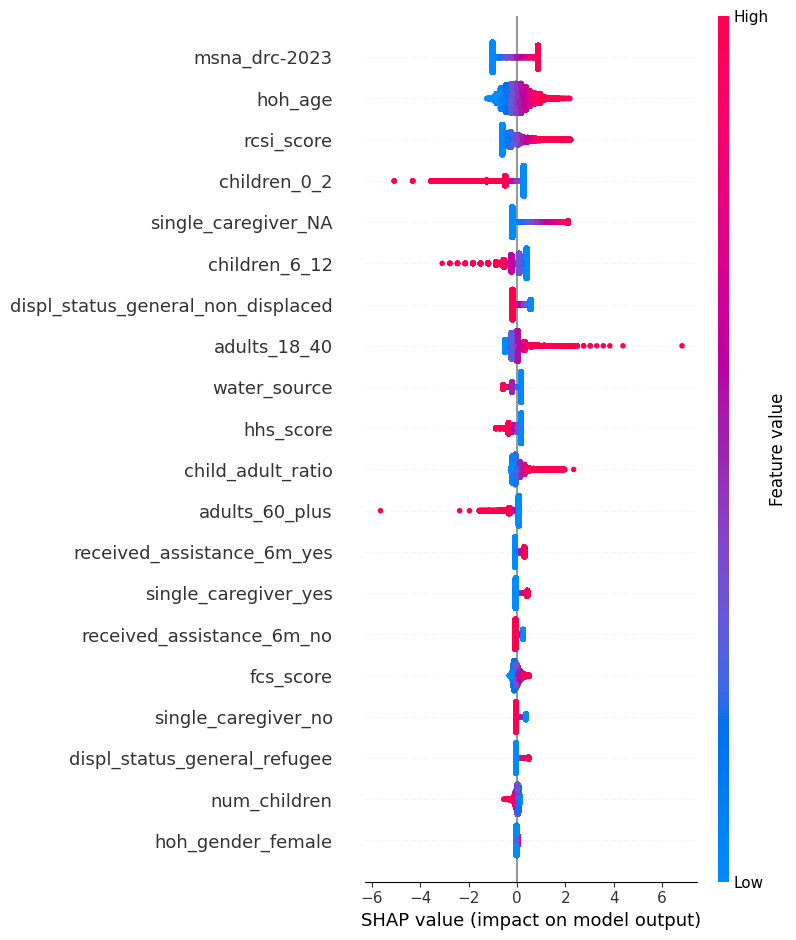

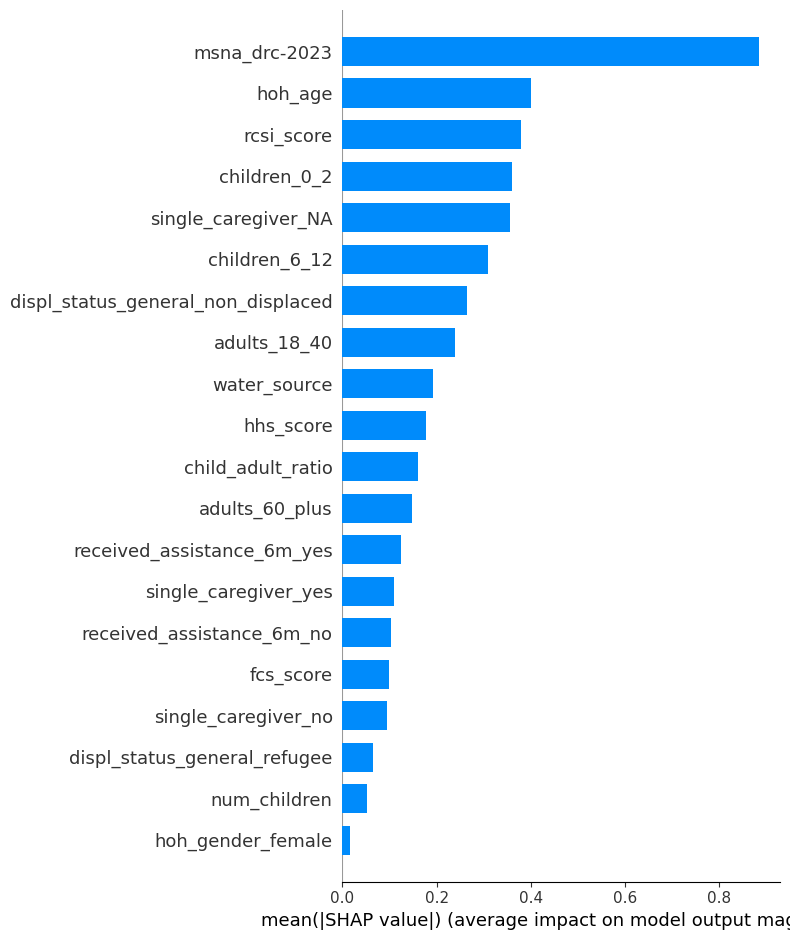

Most important feature: msna_drc-2023


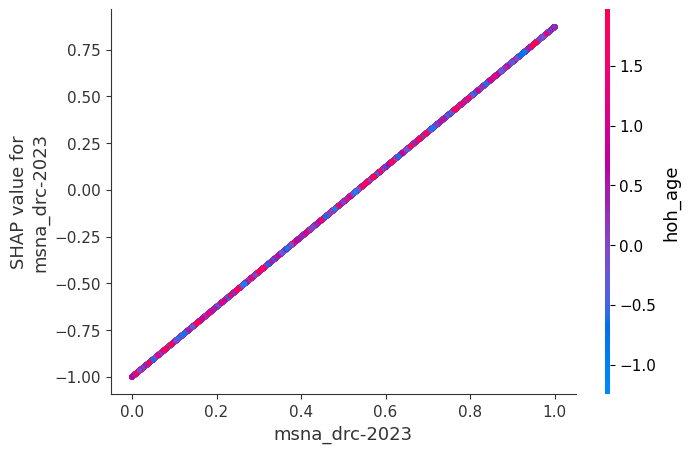

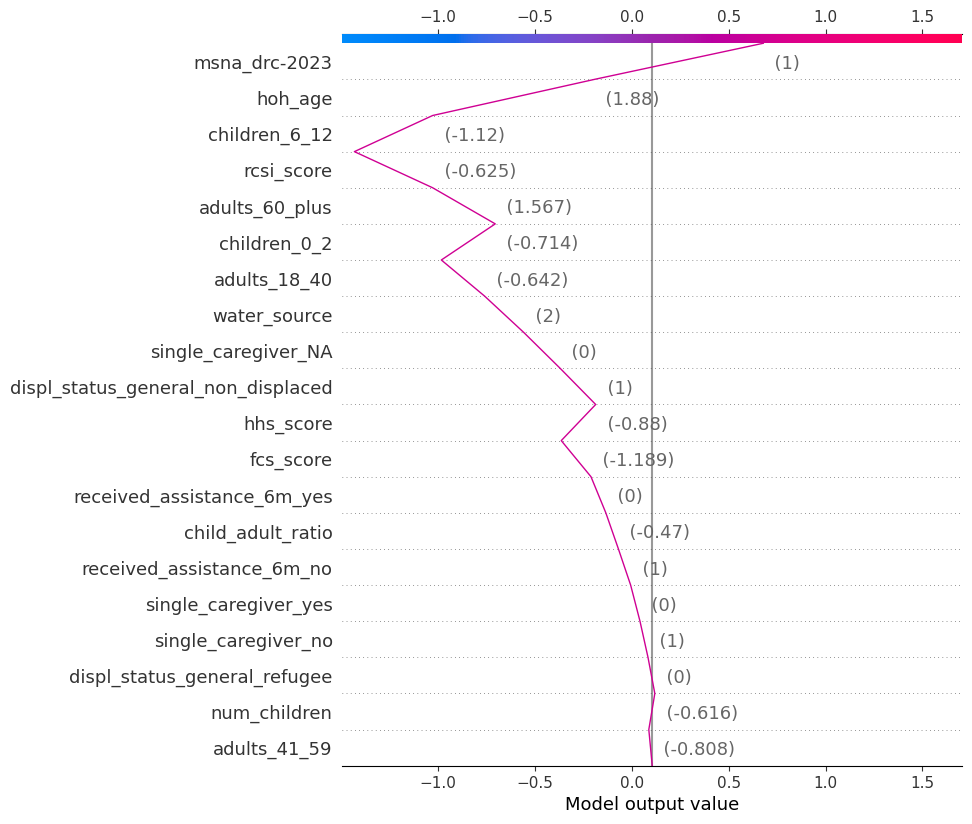

In [14]:
import numpy as np

# Initialize the SHAP explainer
explainer = shap.LinearExplainer(best_model, X_train_resampled)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train_resampled)

# Global feature importance plot (original summary plot)
shap.summary_plot(shap_values, X_train_resampled, feature_names=X_train.columns)

# 1. Feature Importance Bar Plot
shap.summary_plot(shap_values, X_train_resampled, feature_names=X_train.columns, plot_type="bar")

# Dynamically identify the most important feature based on mean absolute SHAP value
mean_shap_values = np.abs(shap_values).mean(axis=0)
most_important_feature = X_train_resampled.columns[np.argmax(mean_shap_values)]
print(f"Most important feature: {most_important_feature}")

# 2. SHAP Dependence Plot for the most important feature
shap.dependence_plot(most_important_feature, shap_values, X_train_resampled)

# 3. SHAP Force Plot (Local Explanation)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_train_resampled.iloc[0])

# 4. SHAP Decision Plot
shap.decision_plot(explainer.expected_value, shap_values[0], X_train_resampled.iloc[0], feature_names=list(X_train.columns))
